# Concrete Slump Test Regression

The concrete slump test measures the consistency of fresh concrete before it sets. It is performed to check the workability of freshly made concrete, and therefore the ease with which concrete flows. It can also be used as an indicator of an improperly mixed batch.

<img src="https://i0.wp.com/civiconcepts.com/wp-content/uploads/2019/08/Slump-Cone-test-of-concrete.jpg?fit=977%2C488&ssl=1">

Our data set consists of various cement properties and the resulting slump test metrics in cm. Later on the set concrete is tested for its compressive strength 28 days later.

Input variables (7)(component kg in one M^3 concrete):
* Cement
* Slag
* Fly ash
* Water
* SP
* Coarse Aggr.
* Fine Aggr.

Output variables (3):
* SLUMP (cm)
* FLOW (cm)
* **28-day Compressive Strength (Mpa)**

Data Source: https://archive.ics.uci.edu/ml/datasets/Concrete+Slump+Test

*Credit: Yeh, I-Cheng, "Modeling slump flow of concrete using second-order regressions and artificial neural networks," Cement and Concrete Composites, Vol.29, No. 6, 474-480, 2007.*

# Importing dependencies

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# %matplotlib inline
# %matplotlib notebook

# !pip install termcolor
import colorama
from colorama import Fore, Style  # makes strings colored
from termcolor import colored
from termcolor import cprint

# plt.rcParams["figure.figsize"] = (10,6)
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Some Useful User-Defined-Functions

In [3]:
def missing_values(df):
    missing_number = df.isnull().sum().sort_values(ascending=False)
    missing_percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_values = pd.concat([missing_number, missing_percent], axis=1, keys=['Missing_Number', 'Missing_Percent'])
    return missing_values[missing_values['Missing_Number']>0]

###############################################################################

def first_looking(df):
    print(colored("Shape:", 'yellow', attrs=['bold']), df.shape,'\n', 
          colored('*'*100, 'red', attrs=['bold']),
          colored("\nInfo:\n",'yellow', attrs=['bold']), sep='')
    print(df.info(), '\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Number of Uniques:\n", 'yellow', attrs=['bold']), df.nunique(),'\n',
          colored('*'*100, 'red', attrs=['bold']), sep='')
#     print(colored("Missing Values:\n", 'yellow', attrs=['bold']), missing_values(df),'\n', 
#           colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("All Columns:", 'yellow', attrs=['bold']), *list(df.columns), sep='\n- ') 
    print(colored('*'*100, 'red', attrs=['bold']), sep='')

#     df.columns= df.columns.str.lower().str.replace('&', '_').str.replace(' ', '_')
    
#     print(colored("Columns after rename:", 'yellow', attrs=['bold']), *list(df.columns), sep='\n- ')
#     print(colored('*'*100, 'red', attrs=['bold']), sep='')
    
###############################################################################
## To view summary information about the columns

def summary(column):
    print(colored("Column: ",'yellow', attrs=['bold']), column)
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing values: ", 'yellow', attrs=['bold']), df[column].isnull().sum())
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing values(%): ", 'yellow', attrs=['bold']), round(df[column].isnull().sum()/df.shape[0]*100, 2))
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Unique values: ", 'yellow', attrs=['bold']), df[column].nunique())
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Value counts: \n", 'yellow', attrs=['bold']), df[column].value_counts(dropna = False), sep='')
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    
###############################################################################
## To view summary_ information about the columns

def summary_(column):
    print(colored("Column: ",'yellow', attrs=['bold']), column)
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing values: ", 'yellow', attrs=['bold']), df[column].isnull().sum())
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Missing values(%): ", 'yellow', attrs=['bold']), round(df[column].isnull().sum()/df.shape[0]*100, 2))
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
    print(colored("Unique values: ", 'yellow', attrs=['bold']), df[column].nunique())
    print(colored('*'*100, 'red', attrs=['bold']), sep='')
                    
############################################################################### 

def multicolinearity_control(df):                    
    df_temp = df.corr()
    count = 'Done'
    feature =[]
    collinear= []
    for col in df_temp.columns:
        for i in df_temp.index:
            if abs(df_temp[col][i] > .9 and df_temp[col][i] < 1):
                    feature.append(col)
                    collinear.append(i)
                    cprint(f"Multicolinearity alert in between --> {col} - {i} --> {round(df_temp[col][i], 6)}", "red", attrs=["bold"])
    else:
#         cprint(f"There is NO multicollinearity problem.", "blue", attrs=["bold"])
        pass
                    
###############################################################################

def duplicate_values(df):
    print(colored("Duplicate check...", 'yellow', attrs=['bold']), sep='')
    duplicate_values = df.duplicated(subset=None, keep='first').sum()
    if duplicate_values > 0:
        df.drop_duplicates(keep='first', inplace=True)
        print(duplicate_values, colored(" Duplicates were dropped!"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There is no duplicate value"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')     

###############################################################################
        
def drop_columns(df, drop_columns):
    if drop_columns !=[]:
        df.drop(drop_columns, axis=1, inplace=True)
        print(drop_columns, 'were dropped')
    else:
        print(colored('Missing value control...', 'yellow', attrs=['bold']),'\n',
              colored('If there is a missing value above the limit you have given, the relevant columns are dropped and an information is given.'), sep='')

###############################################################################

def drop_null(df, limit):
    for i in df.isnull().sum().index:
        if (df.isnull().sum()[i]/df.shape[0]*100)>limit:
            print(df.isnull().sum()[i], 'percent of', i ,'were null and dropped')
            df.drop(i, axis=1, inplace=True)
    print(colored('Last shape after missing value control:', 'yellow', attrs=['bold']), df.shape, '\n', 
          colored('*'*100, 'red', attrs=['bold']), sep='')

###############################################################################

def shape_control():
    print('df.shape:', df.shape)
    print('X.shape:', X.shape)
    print('y.shape:', y.shape)
    print('X_train.shape:', X_train.shape)
    print('y_train.shape:', y_train.shape)
    print('X_test.shape:', X_test.shape)
    print('y_test.shape:', y_test.shape)

###############################################################################  

## show values in bar graphic
def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height()
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 
    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)
        
###############################################################################   

def missing_values(df):
#     print(colored("Missing value check...", 'yellow', attrs=['bold']), sep='')
    missing_values = df.isnull().sum().values.sum()
    if missing_values > 0:
        print(missing_values, colored(" Duplicates were dropped!"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')
    else:
        print(colored("There is no missing value"),'\n',
              colored('*'*100, 'red', attrs=['bold']), sep='')     

###############################################################################

def color_red(val):
    
    if (val > 0.90 and val < 0.99) or (val < -0.90 and val > -0.99):
        color = 'red'
    else:
        color = 'black'
    return f'color: {color}'

# %90 ve üzeri bir korelasyon multicollinearity göstergesi olarak değerlendirilebilir.
###############################################################################

In [4]:
def show_distribution_density(col):

    min_val = col.min()
    max_val = col.max()
    mean_val = col.mean()
    med_val = col.median()
    mod_val = col.mode()[0]

    print('Minimum:{:.2f}\nMean:{:.2f}\nMedian:{:.2f}\nMode:{:.2f}\nMaximum:{:.2f}\n'.format(min_val,
                                                                                            mean_val,
                                                                                            med_val,
                                                                                            mod_val,
                                                                                            max_val))

    fig = plt.figure(figsize = (15,10))
    
    plt.subplot(3, 1, 1)
    plt.hist(col)
    plt.ylabel('Frequency', fontsize=10)
    plt.axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Minimum')
    plt.axvline(x=mean_val, color = 'cyan', linestyle='dashed', linewidth = 2, label='Mean')
    plt.axvline(x=med_val, color = 'red', linestyle='dashed', linewidth = 2, label='Median')
    plt.axvline(x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2, label='Mode')
    plt.axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Maximum')
    plt.legend(loc='upper right')
    
    plt.subplot(3, 1, 2) 
    plt.boxplot(col, vert=False)
    
    plt.subplot(3, 1, 3)
    col.plot.density()
    plt.axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Minimum')
    plt.axvline(x=col.mean(), color = 'cyan', linestyle='dashed', linewidth = 2, label = 'Mean')
    plt.axvline(x=col.median(), color = 'red', linestyle='dashed', linewidth = 2, label = 'Median')
    plt.axvline(x=col.mode()[0], color = 'yellow', linestyle='dashed', linewidth = 2, label = 'Mode')
    plt.axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Maximum')
    plt.legend(loc='upper right')

    fig.suptitle('Column Distribution & Density', fontsize=15)
    
    plt.show()    

In [5]:
def show_density(col):

    fig = plt.figure(figsize=(15,5))

    df[col].plot.density()

    plt.title('Data Density', fontsize=15)

    plt.axvline(x=min_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Minimum')
    plt.axvline(x=col.mean(), color = 'cyan', linestyle='dashed', linewidth = 2, label = 'Mean')
    plt.axvline(x=col.median(), color = 'red', linestyle='dashed', linewidth = 2, label = 'Median')
    plt.axvline(x=col.mode()[0], color = 'yellow', linestyle='dashed', linewidth = 2, label = 'Mode')
    plt.axvline(x=max_val, color = 'gray', linestyle='dashed', linewidth = 2, label='Maximum')
    plt.legend(loc='upper right')

    plt.show()

In [6]:
def train_val(y_train, y_train_pred, y_test, y_pred, model_name):
    
    scores = {model_name+"_train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    model_name+"_test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

# Loading data

In [7]:
df0 = pd.read_csv('cement_slump.csv')
df = df0.copy()

In [8]:
df.head()

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
0,273.000,82.000,105.000,210.000,9.000,904.000,680.000,23.000,62.000,34.990
1,163.000,149.000,191.000,180.000,12.000,843.000,746.000,0.000,20.000,41.140
2,162.000,148.000,191.000,179.000,16.000,840.000,743.000,1.000,20.000,41.810
3,162.000,148.000,190.000,179.000,19.000,838.000,741.000,3.000,21.500,42.080
4,154.000,112.000,144.000,220.000,10.000,923.000,658.000,20.000,64.000,26.820


In [9]:
df.tail()

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
98,248.300,101.000,239.100,168.900,7.700,954.200,640.600,0.000,20.000,49.970
99,248.000,101.000,239.900,169.100,7.700,949.900,644.100,2.000,20.000,50.230
100,258.800,88.000,239.600,175.300,7.600,938.900,646.000,0.000,20.000,50.500
101,297.100,40.900,239.900,194.000,7.500,908.900,651.800,27.500,67.000,49.170
102,348.700,0.100,223.100,208.500,9.600,786.200,758.100,29.000,78.000,48.700


In [10]:
df.sample(5)

,Cement,Slag,Fly ash,Water,SP,Coarse Aggr.,Fine Aggr.,SLUMP(cm),FLOW(cm),Compressive Strength (28-day)(Mpa)
49,326.000,0.000,167.000,174.000,6.000,884.000,792.000,21.500,42.000,52.650
79,141.100,0.600,209.500,188.800,4.600,996.100,789.200,23.500,53.000,30.430
60,278.000,0.000,117.000,205.000,9.000,875.000,799.000,19.000,48.000,32.710
80,140.100,4.200,215.900,193.900,4.700,1049.500,710.100,24.500,57.000,26.420
19,296.000,97.000,0.000,219.000,9.000,932.000,685.000,15.000,48.500,29.230


In [11]:
df.columns

Index(['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse Aggr.',
       'Fine Aggr.', 'SLUMP(cm)', 'FLOW(cm)',
       'Compressive Strength (28-day)(Mpa)'],
      dtype='object')

In [12]:
# !pip install skimpy
from skimpy import clean_columns

columns = ['Cement', 'Slag', 'Fly ash', 'Water', 'SP', 'Coarse Aggr.',
       'Fine Aggr.', 'SLUMP(cm)', 'FLOW(cm)',
       'Compressive Strength (28-day)(Mpa)']

messy_df = pd.DataFrame(data = [], columns = columns, index = [0])
clean_df = clean_columns(messy_df)
clean_df.columns.tolist()

['cement',
 'slag',
 'fly_ash',
 'water',
 'sp',
 'coarse_aggr',
 'fine_aggr',
 'slump_cm',
 'flow_cm',
 'compressive_strength_28_day_mpa']

In [13]:
df.columns = clean_df.columns.tolist()
df.columns

Index(['cement', 'slag', 'fly_ash', 'water', 'sp', 'coarse_aggr', 'fine_aggr',
       'slump_cm', 'flow_cm', 'compressive_strength_28_day_mpa'],
      dtype='object')

# EDA and Graphical analysis
## First Looking to the Data Set

In [14]:
first_looking(df)

Shape:(103, 10)
****************************************************************************************************
Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103 entries, 0 to 102
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   cement                           103 non-null    float64
 1   slag                             103 non-null    float64
 2   fly_ash                          103 non-null    float64
 3   water                            103 non-null    float64
 4   sp                               103 non-null    float64
 5   coarse_aggr                      103 non-null    float64
 6   fine_aggr                        103 non-null    float64
 7   slump_cm                         103 non-null    float64
 8   flow_cm                          103 non-null    float64
 9   compressive_strength_28_day_mpa  103 non-null    float64
dtypes: float64(10)
memory 

In [15]:
df.describe()

,cement,slag,fly_ash,water,sp,coarse_aggr,fine_aggr,slump_cm,flow_cm,compressive_strength_28_day_mpa
count,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000,103.000
mean,229.894,77.974,149.015,197.168,8.540,883.979,739.605,18.049,49.611,36.039
std,78.877,60.461,85.418,20.208,2.808,88.391,63.342,8.751,17.569,7.837
min,137.000,0.000,0.000,160.000,4.400,708.000,640.600,0.000,20.000,17.190
25%,152.000,0.050,115.500,180.000,6.000,819.500,684.500,14.500,38.500,30.900
50%,248.000,100.000,164.000,196.000,8.000,879.000,742.700,21.500,54.000,35.520
75%,303.900,125.000,235.950,209.500,10.000,952.800,788.000,24.000,63.750,41.205
max,374.000,193.000,260.000,240.000,19.000,1049.900,902.000,29.000,78.000,58.530


In [16]:
duplicate_values(df)

Duplicate check...
There is no duplicate value
****************************************************************************************************


In [17]:
missing_values(df)

There is no missing value
****************************************************************************************************


## Examination of Features and Target

###  Target

In [18]:
target = 'compressive_strength_28_day_mpa'
# cprint(f'Have a first look to {target}:', 'red', 'on_white', attrs=['bold'])
summary(target)

Column:  compressive_strength_28_day_mpa
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  83
****************************************************************************************************
Value counts: 
34.990    2
41.140    2
41.270    2
35.520    2
44.080    2
         ..
58.530    1
45.690    1
32.040    1
36.460    1
48.700    1
Name: compressive_strength_28_day_mpa, Length: 83, dtype: int64
****************************************************************************************************


Minimum:17.19
Mean:36.04
Median:35.52
Mode:26.42
Maximum:58.53



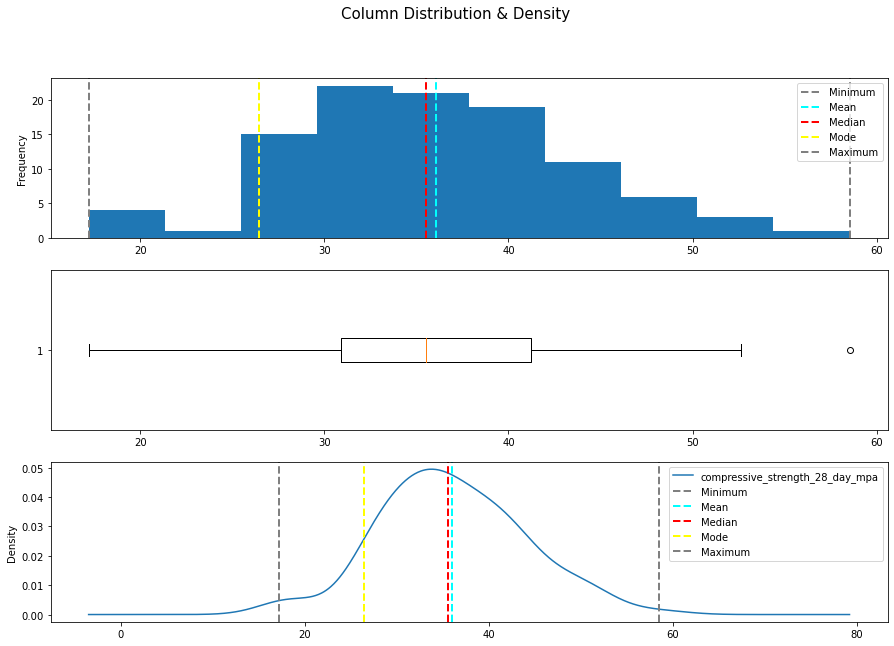

In [19]:
show_distribution_density(df['compressive_strength_28_day_mpa'])

In [111]:
def outlier(col):
    print('Num_Outliers:', len(list(i for i in col if i > (np.percentile(col, 75) + 1.5 * stats.iqr(col)) or \
                              i < (np.percentile(col, 25) - 1.5 * stats.iqr(col)))))

    print('Outliers    :', list(i for i in col if i > (np.percentile(col, 75) + 1.5 * stats.iqr(col)) or \
                              i < (np.percentile(col, 25) - 1.5 * stats.iqr(col))))

In [120]:
outlier(df['compressive_strength_28_day_mpa'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Num_Outliers: 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Outliers    : [58.53]


###  'cement' column

In [20]:
summary('cement')

Column:  cement
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  80
****************************************************************************************************
Value counts: 
159.000    4
145.000    3
140.000    3
320.000    2
160.000    2
          ..
163.000    1
342.000    1
356.000    1
309.000    1
348.700    1
Name: cement, Length: 80, dtype: int64
****************************************************************************************************


In [114]:
outlier(df['cement'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Num_Outliers: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Outliers    : []


Minimum:137.00
Mean:229.89
Median:248.00
Mode:159.00
Maximum:374.00



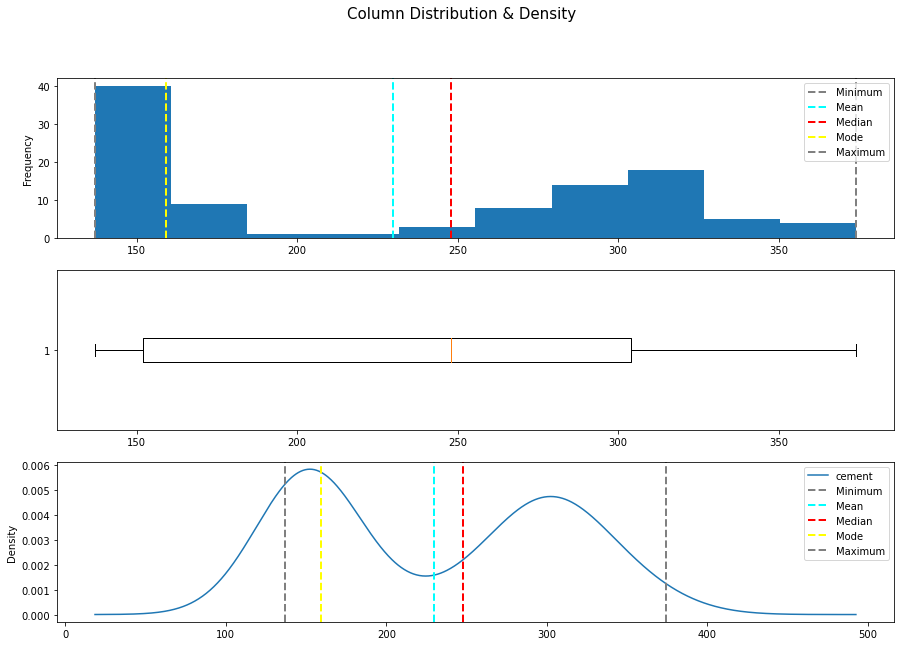

In [21]:
show_distribution_density(df['cement'])

###  'slag' column

In [22]:
summary('slag')

Column:  slag
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  63
****************************************************************************************************
Value counts: 
0.000      26
106.000     5
107.000     3
148.000     2
112.000     2
           ..
149.000     1
110.000     1
124.000     1
131.000     1
0.100       1
Name: slag, Length: 63, dtype: int64
****************************************************************************************************


Minimum:0.00
Mean:77.97
Median:100.00
Mode:0.00
Maximum:193.00



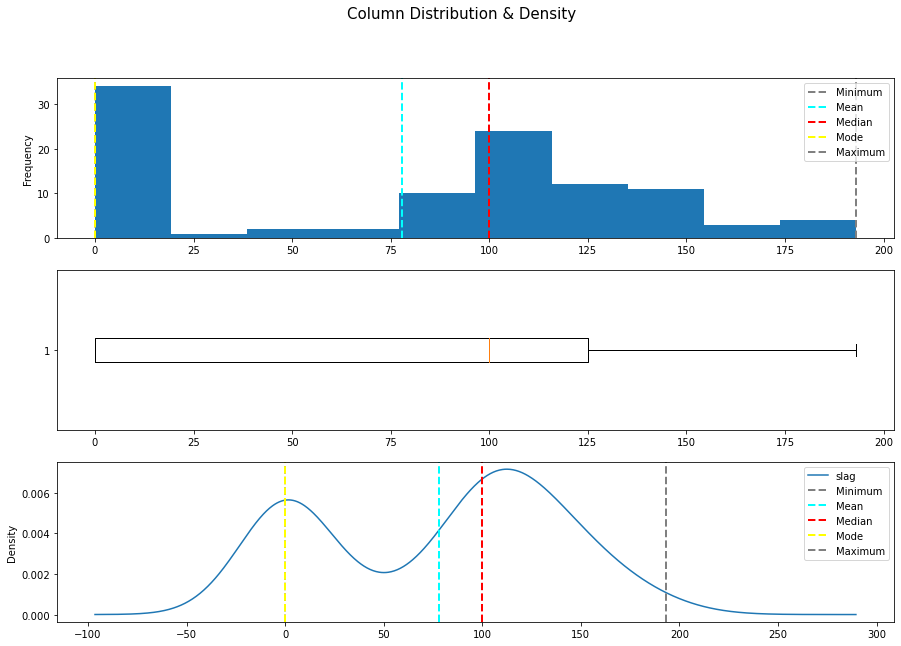

In [23]:
show_distribution_density(df['slag'])

In [115]:
outlier(df['slag'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Num_Outliers: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Outliers    : []


###  'fly_ash' column

In [24]:
summary('fly_ash')

Column:  fly_ash
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  58
****************************************************************************************************
Value counts: 
0.000      20
164.000     4
136.000     4
239.000     3
240.000     3
239.900     3
167.000     3
121.000     2
191.000     2
239.800     2
187.000     2
142.000     2
143.000     2
137.000     2
149.000     2
178.000     2
139.000     2
115.000     2
227.000     2
260.000     1
239.100     1
100.000     1
198.100     1
209.500     1
215.900     1
226.100     1
239.600     1
234.900     1
239.500     1
238.900     1
239.200     1
239.700     1
238.800     1
238.300     1
238.500     1
116.000     

Minimum:0.00
Mean:149.01
Median:164.00
Mode:0.00
Maximum:260.00



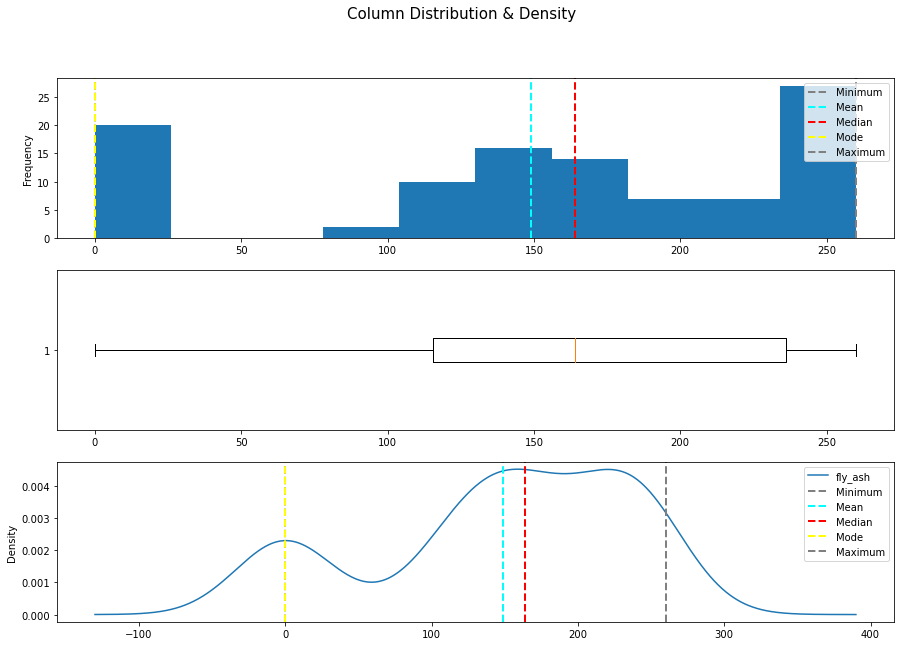

In [25]:
show_distribution_density(df['fly_ash'])

In [116]:
outlier(df['fly_ash'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Num_Outliers: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Outliers    : []


###  'water' column

In [26]:
summary('water')

Column:  water
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  70
****************************************************************************************************
Value counts: 
210.000    3
179.000    3
183.000    3
180.000    3
168.000    3
          ..
177.000    1
231.000    1
195.000    1
206.000    1
208.500    1
Name: water, Length: 70, dtype: int64
****************************************************************************************************


Minimum:160.00
Mean:197.17
Median:196.00
Mode:168.00
Maximum:240.00



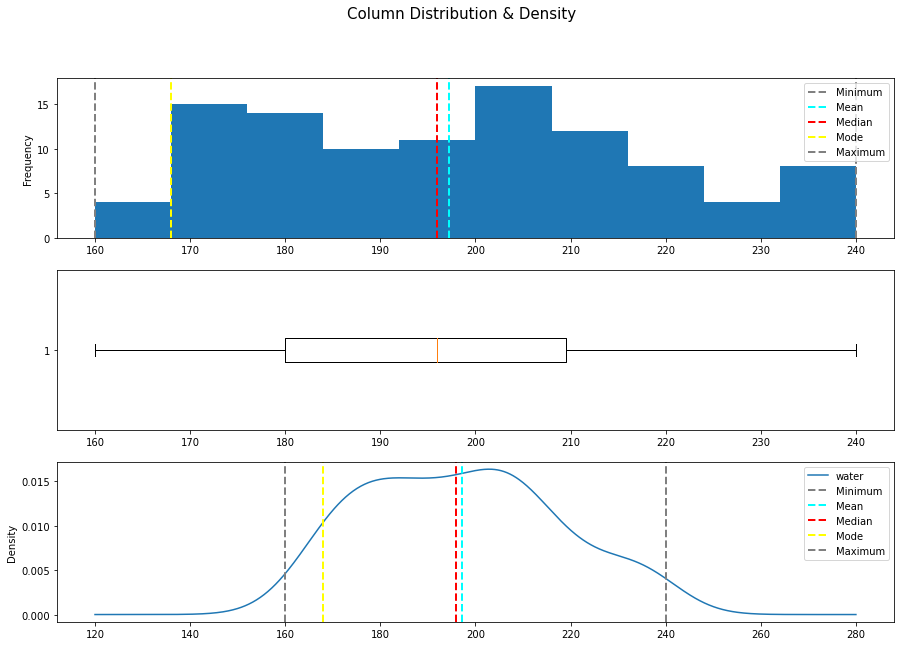

In [27]:
show_distribution_density(df['water'])

###  'sp' column

In [28]:
summary('sp')

Column:  sp
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  32
****************************************************************************************************
Value counts: 
6.000     24
11.000    12
10.000    11
9.000     11
12.000     6
7.000      5
7.400      3
7.700      2
7.500      2
8.300      2
13.000     2
8.000      2
6.500      2
7.600      1
5.700      1
7.100      1
6.700      1
8.900      1
6.200      1
4.900      1
5.500      1
5.300      1
9.200      1
4.700      1
4.600      1
4.400      1
5.000      1
15.000     1
18.000     1
19.000     1
16.000     1
9.600      1
Name: sp, dtype: int64
********************************************************************

Minimum:4.40
Mean:8.54
Median:8.00
Mode:6.00
Maximum:19.00



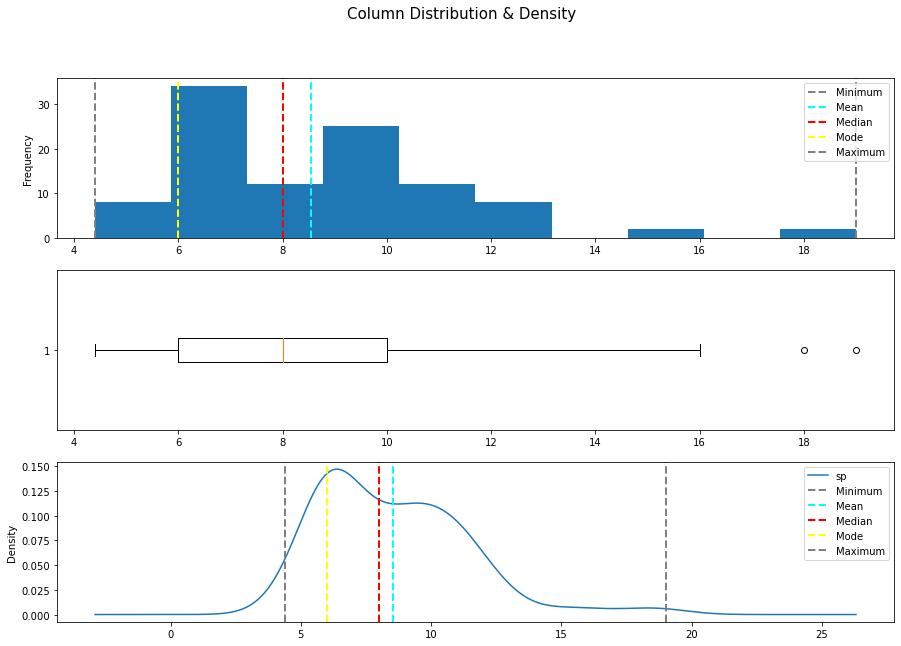

In [29]:
show_distribution_density(df['sp'])

In [117]:
outlier(df['sp'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Num_Outliers: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Outliers    : []


###  'coarse_aggr' column

In [30]:
summary('coarse_aggr')

Column:  coarse_aggr
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  92
****************************************************************************************************
Value counts: 
904.000    3
750.000    2
871.000    2
883.000    2
959.000    2
          ..
835.000    1
810.000    1
708.000    1
759.000    1
786.200    1
Name: coarse_aggr, Length: 92, dtype: int64
****************************************************************************************************


Minimum:708.00
Mean:883.98
Median:879.00
Mode:904.00
Maximum:1049.90



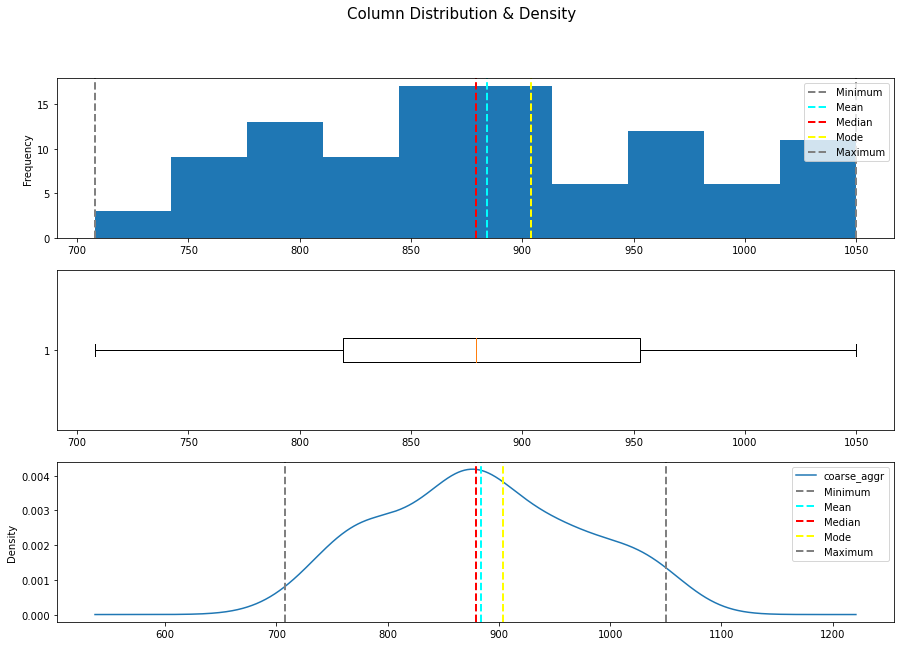

In [31]:
show_distribution_density(df['coarse_aggr'])

###  'fine_aggr' column

In [32]:
summary('fine_aggr')

Column:  fine_aggr
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  90
****************************************************************************************************
Value counts: 
757.000    4
680.000    2
644.100    2
778.000    2
827.000    2
          ..
721.000    1
774.000    1
655.000    1
650.000    1
758.100    1
Name: fine_aggr, Length: 90, dtype: int64
****************************************************************************************************


Minimum:640.60
Mean:739.60
Median:742.70
Mode:757.00
Maximum:902.00



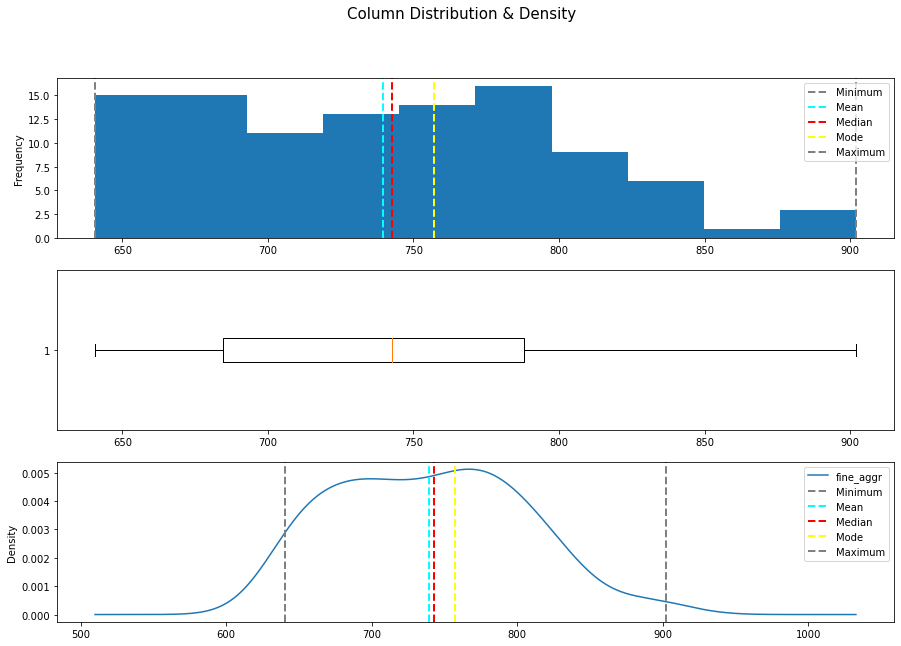

In [33]:
show_distribution_density(df['fine_aggr'])

###  'slump_cm' column

In [34]:
summary('slump_cm')

Column:  slump_cm
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  39
****************************************************************************************************
Value counts: 
0.000     11
23.000     8
25.000     8
24.000     7
21.000     5
14.500     5
23.500     5
25.500     3
27.500     3
26.500     3
24.500     3
19.000     3
20.000     3
23.750     2
21.500     2
2.000      2
22.000     2
17.000     2
3.000      2
20.500     2
18.000     2
13.000     2
12.000     2
15.500     1
9.500      1
21.250     1
16.250     1
26.000     1
27.000     1
22.500     1
8.000      1
16.000     1
17.500     1
2.500      1
1.000      1
25.750     1
15.000     1
24.750     1
29.000 

Minimum:0.00
Mean:18.05
Median:21.50
Mode:0.00
Maximum:29.00



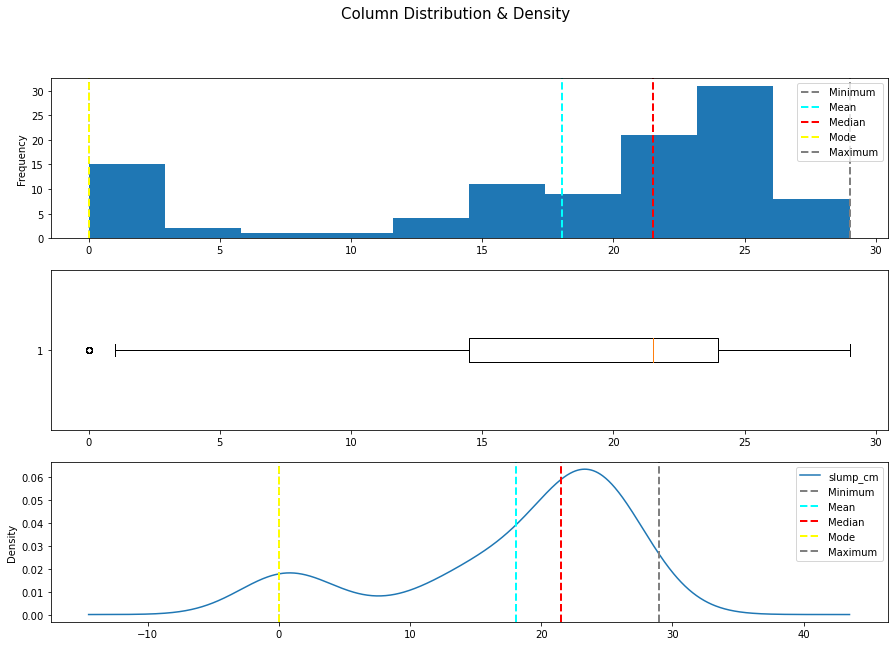

In [35]:
show_distribution_density(df['slump_cm'])

In [118]:
outlier(df['slump_cm'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Num_Outliers: 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Outliers    : []


###  'flow_cm' column

In [36]:
summary('flow_cm')

Column:  flow_cm
****************************************************************************************************
Missing values:  0
****************************************************************************************************
Missing values(%):  0.0
****************************************************************************************************
Unique values:  51
****************************************************************************************************
Value counts: 
20.000    17
64.000     6
67.000     4
60.000     4
46.000     3
48.000     3
51.000     3
61.000     3
54.000     3
70.000     3
78.000     3
62.000     2
69.000     2
65.000     2
57.000     2
53.000     2
49.000     2
58.000     2
68.500     2
55.000     2
58.500     2
48.500     2
50.000     1
27.000     1
63.000     1
47.000     1
39.000     1
63.500     1
41.500     1
31.000     1
75.000     1
36.500     1
52.500     1
27.500     1
40.000     1
64.500     1
61.500     1
30.000     1
42.000  

Minimum:20.00
Mean:49.61
Median:54.00
Mode:20.00
Maximum:78.00



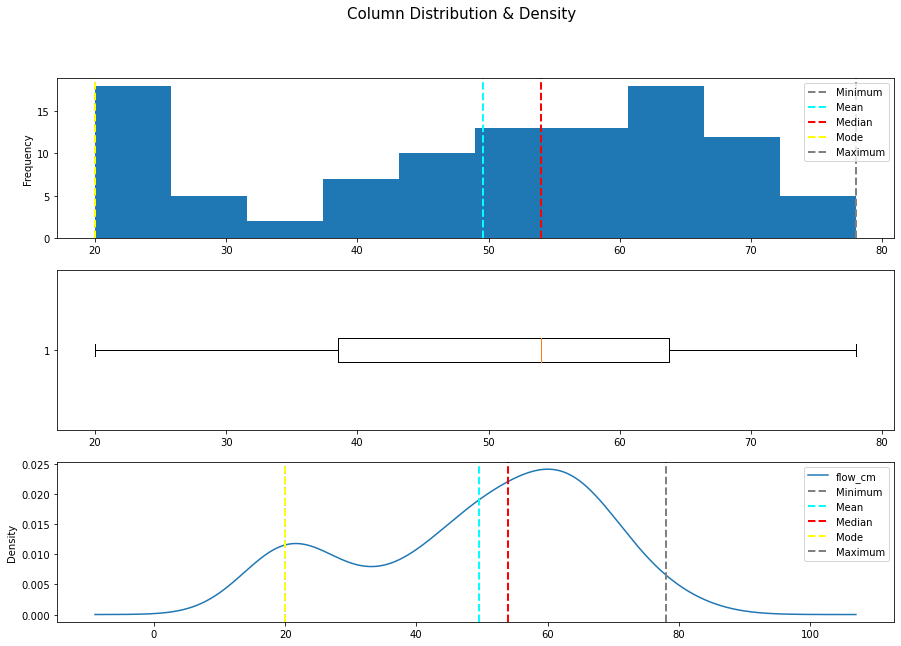

In [37]:
show_distribution_density(df['flow_cm'])

## Multicollinearity Control

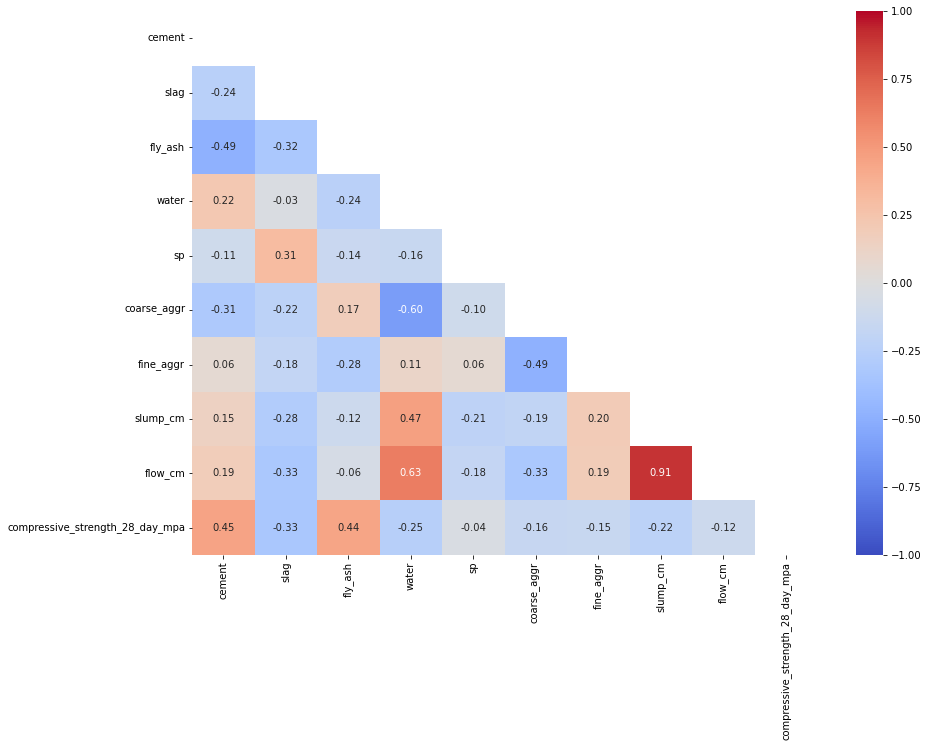

In [38]:
matrix = np.triu(df.corr())
fig, ax = plt.subplots(figsize=(14,10)) 
sns.heatmap (df.corr(), annot=True, fmt= '.2f', vmin=-1, vmax=1, center=0, cmap='coolwarm',mask=matrix, ax=ax);

In [39]:
corr_by_target = df.corr()[target]
corr_by_target

cement                             0.446
slag                              -0.332
fly_ash                            0.444
water                             -0.254
sp                                -0.038
coarse_aggr                       -0.161
fine_aggr                         -0.155
slump_cm                          -0.223
flow_cm                           -0.124
compressive_strength_28_day_mpa    1.000
Name: compressive_strength_28_day_mpa, dtype: float64

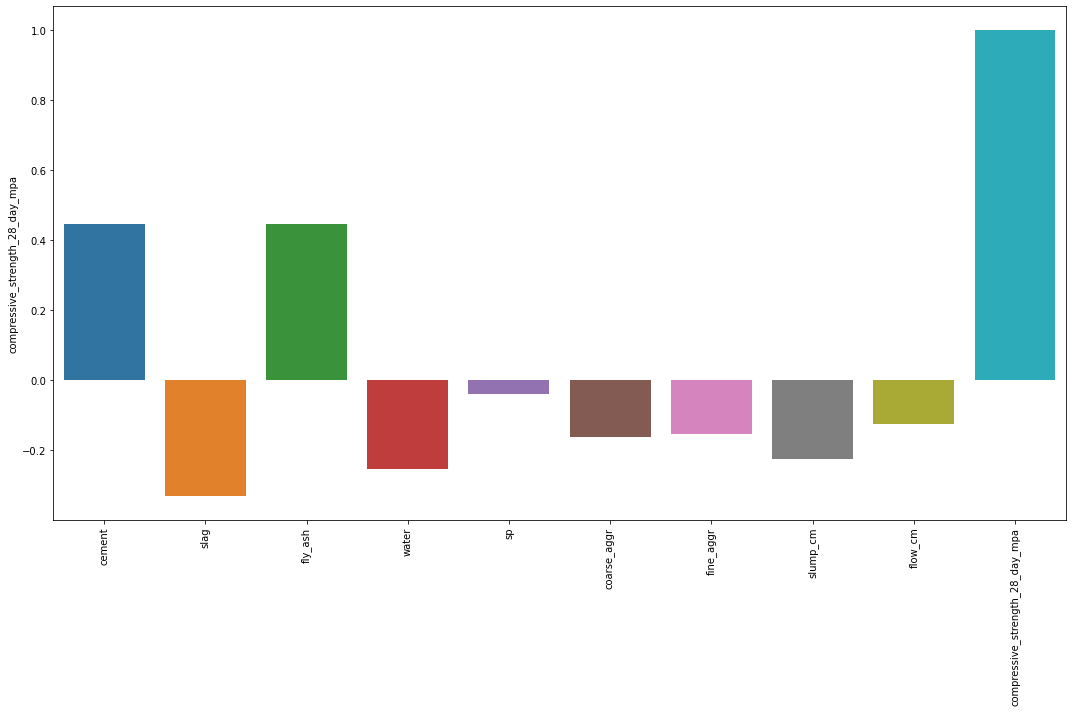

In [40]:
plt.figure(figsize = (15,10))
sns.barplot(x = corr_by_target.index, y = corr_by_target)
plt.xticks(rotation=90)
plt.tight_layout();

In [41]:
df.corr().style.applymap(color_red)

,cement,slag,fly_ash,water,sp,coarse_aggr,fine_aggr,slump_cm,flow_cm,compressive_strength_28_day_mpa
cement,1.000000,-0.243553,-0.486535,0.221091,-0.106387,-0.309857,0.056959,0.145913,0.186461,0.445656
slag,-0.243553,1.000000,-0.322619,-0.026775,0.306504,-0.223792,-0.183522,-0.284037,-0.327231,-0.331522
fly_ash,-0.486535,-0.322619,1.000000,-0.241321,-0.143508,0.172620,-0.282854,-0.118621,-0.055423,0.444380
water,0.221091,-0.026775,-0.241321,1.000000,-0.155456,-0.602201,0.114591,0.466568,0.632026,-0.254320
sp,-0.106387,0.306504,-0.143508,-0.155456,1.000000,-0.104159,0.058290,-0.212902,-0.176314,-0.037909
coarse_aggr,-0.309857,-0.223792,0.172620,-0.602201,-0.104159,1.000000,-0.488537,-0.188157,-0.325787,-0.160610
fine_aggr,0.056959,-0.183522,-0.282854,0.114591,0.058290,-0.488537,1.000000,0.202272,0.190370,-0.154532
slump_cm,0.145913,-0.284037,-0.118621,0.466568,-0.212902,-0.188157,0.202272,1.000000,0.906135,-0.223499
flow_cm,0.186461,-0.327231,-0.055423,0.632026,-0.176314,-0.325787,0.190370,0.906135,1.000000,-0.124189
compressive_strength_28_day_mpa,0.445656,-0.331522,0.444380,-0.254320,-0.037909,-0.160610,-0.154532,-0.223499,-0.124189,1.000000


In [42]:
multicolinearity_control(df)

Multicolinearity alert in between --> slump_cm - flow_cm --> 0.906135
Multicolinearity alert in between --> flow_cm - slump_cm --> 0.906135


## Handling with Skewness

In [43]:
skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. Overall below abs(1) seems acceptable for the linear models. 
skew_vals = df.skew()
skew_cols = skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols 

sp          1.126
slump_cm   -1.113
dtype: float64

**With np.log**

In [44]:
df_log = df[skew_cols.index].copy()

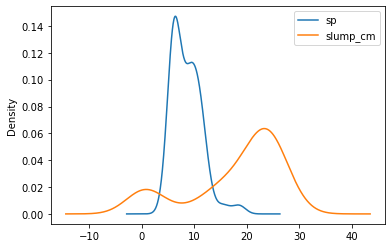

In [45]:
for col in df_log.columns:
    df_log[col].plot.density()
    plt.legend(loc='upper right')   

In [46]:
for col in skew_cols.index.values:
    df_log[col] = df_log[col].apply(np.log1p)
print(df_log[skew_cols.index].skew())

sp          0.371
slump_cm   -1.847
dtype: float64


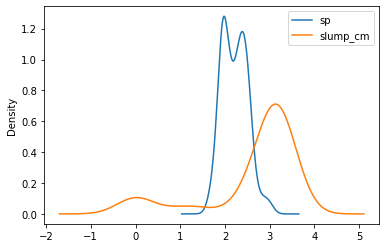

In [47]:
for col in df_log.columns:
    df_log[col].plot.density()
    plt.legend(loc='upper right') 

**With Power Transformer**

In [48]:
df_trans = df[skew_cols.index].copy()

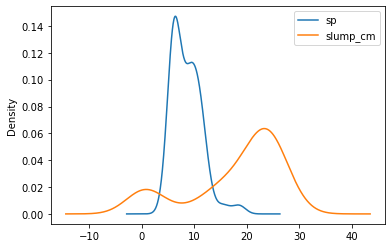

In [49]:
for col in df_trans.columns:
    df_trans[col].plot.density()
    plt.legend(loc='upper right') 

In [50]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
trans= pt.fit_transform(df_trans)
df_trans = pd.DataFrame(trans, columns =skew_cols.index)
print(df_trans.skew())

sp          0.040
slump_cm   -0.877
dtype: float64


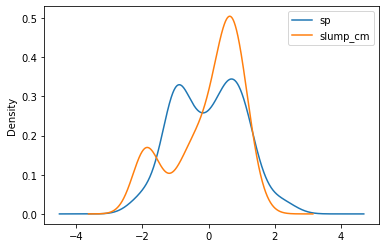

In [51]:
for col in df_trans.columns:
    df_trans[col].plot.density()
    plt.legend(loc='upper right') 

In [52]:
df.columns

Index(['cement', 'slag', 'fly_ash', 'water', 'sp', 'coarse_aggr', 'fine_aggr',
       'slump_cm', 'flow_cm', 'compressive_strength_28_day_mpa'],
      dtype='object')

In [53]:
df_trans.columns

Index(['sp', 'slump_cm'], dtype='object')

In [54]:
df.drop(['sp', 'slump_cm'], axis=1, inplace=True)
df = pd.concat([df, df_trans], axis=1)
df.columns

Index(['cement', 'slag', 'fly_ash', 'water', 'coarse_aggr', 'fine_aggr',
       'flow_cm', 'compressive_strength_28_day_mpa', 'sp', 'slump_cm'],
      dtype='object')

In [55]:
last_column = df.pop('compressive_strength_28_day_mpa')
df.insert(9, 'compressive_strength_28_day_mpa', last_column)
df.head(1)

,cement,slag,fly_ash,water,coarse_aggr,fine_aggr,flow_cm,sp,slump_cm,compressive_strength_28_day_mpa
0,273.000,82.000,105.000,210.000,904.000,680.000,62.000,0.390,0.565,34.990


In [56]:
skew_limit = 0.75 # This is our threshold-limit to evaluate skewness. 
                  # Overall below abs(1) seems acceptable for the linear models.
skew_vals = df.skew()
skew_cols= skew_vals[abs(skew_vals)> skew_limit].sort_values(ascending=False)
skew_cols

slump_cm   -0.877
dtype: float64

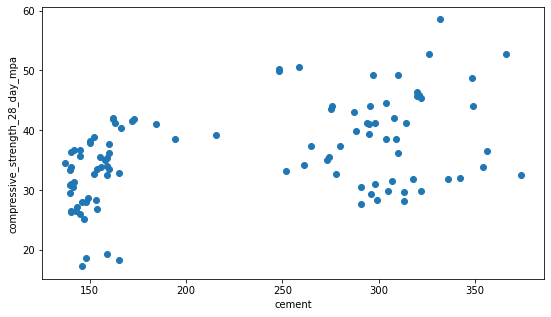

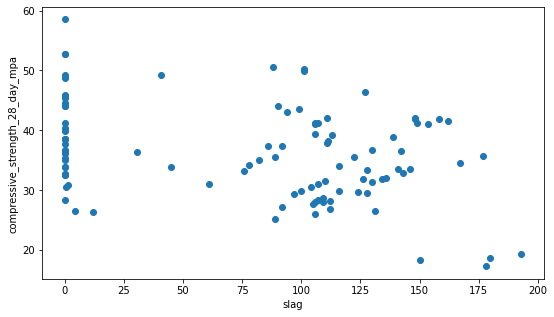

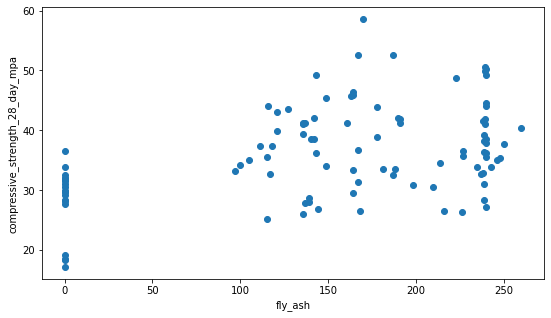

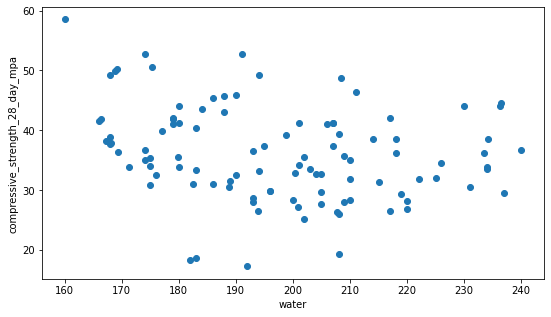

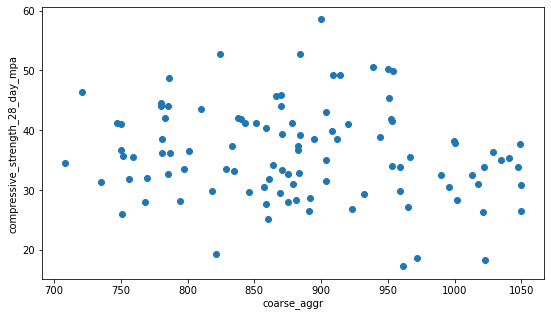

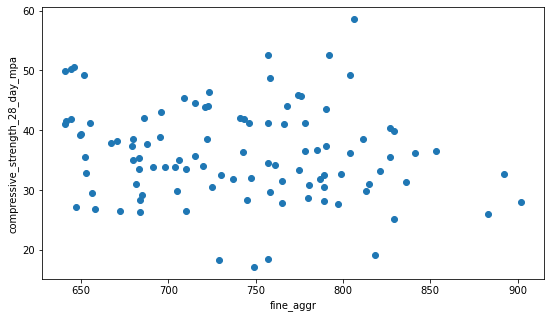

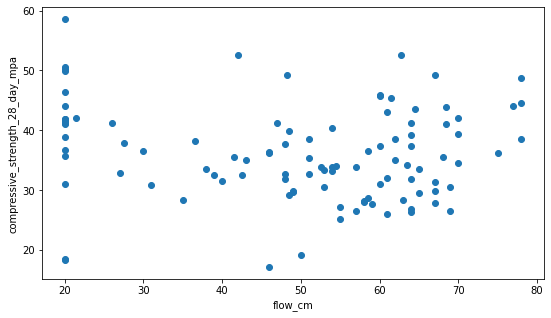

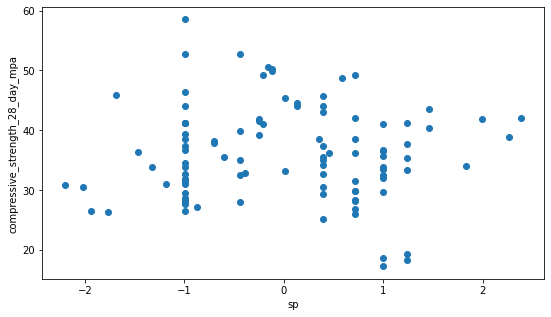

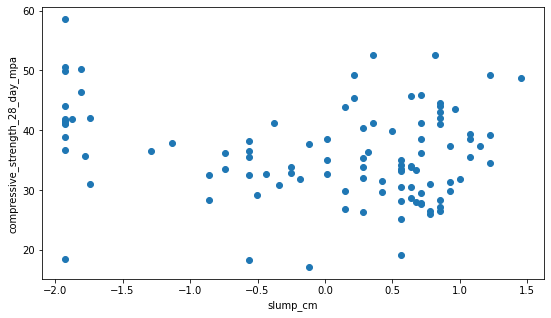

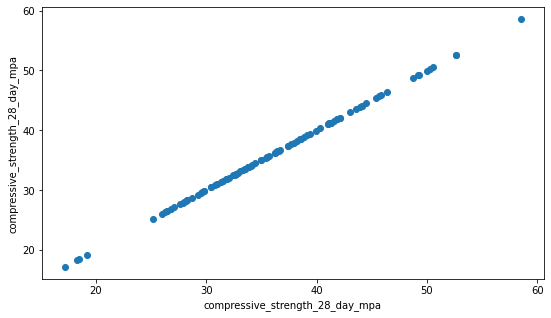

In [57]:
for col in df.columns:
    fig = plt.figure(figsize=(9, 5))
#     ax = fig.gca()
    feature = df[col]
    label = df['compressive_strength_28_day_mpa']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('compressive_strength_28_day_mpa')
    ax.set_title('compressive_strength_28_day_mpa vs ' + col + '- correlation: ' + str(correlation))
plt.show()

# Data Preprocessing 

### Features and target variable

In [58]:
X = df.drop('compressive_strength_28_day_mpa', axis=1)
y = df['compressive_strength_28_day_mpa']

In [59]:
print ('X shape : %d rows\ny shape : %d rows' % (X.shape[0], y.shape[0]))

X shape : 103 rows
y shape : 103 rows


### Splitting data into training and testing

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

In [62]:
print ('Training Set: %d rows\nTest Set    : %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 82 rows
Test Set    : 21 rows


## Scaling

In [63]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

In [64]:
for col in df.columns:
    print(f'{col} range :', np.min(df[col]), "-", np.max(df[col]))

cement range : 137.0 - 374.0
slag range : 0.0 - 193.0
fly_ash range : 0.0 - 260.0
water range : 160.0 - 240.0
coarse_aggr range : 708.0 - 1049.9
fine_aggr range : 640.6 - 902.0
flow_cm range : 20.0 - 78.0
sp range : -2.202923346529185 - 2.3873935274857705
slump_cm range : -1.929018256548279 - 1.4544954663696197
compressive_strength_28_day_mpa range : 17.19 - 58.53


In [65]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train) 
X_test_scaled = scaler.transform(X_test)

In [66]:
X_train_scaled[1]

array([-1.10706235, -0.65473064,  1.0037065 , -1.27667814,  1.91796192,
       -0.53046129,  0.19172619, -1.32949536,  0.64293481])

In [67]:
X_test_scaled[1]

array([-0.80185948,  1.1335507 ,  0.4718536 , -0.8318734 , -0.47655749,
        0.09768775, -1.66762718,  1.26234379, -1.87077039])

#  1. Linear Regression
## 1.a. Model Building

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [69]:
linear = LinearRegression().fit(X_train_scaled, y_train)
print (linear, "\n")

print(colored('*'*100, 'red', attrs=['bold']), sep='')

y_pred = linear.predict(X_test_scaled)
y_train_pred = linear.predict(X_train_scaled)

ls =train_val(y_train, y_train_pred, y_test, y_pred, "linear")
print(ls)

LinearRegression() 

****************************************************************************************************
      linear_train  linear_test
R2           0.909        0.863
mae          1.943        2.203
mse          5.489        8.554
rmse         2.343        2.925


## 1.b. Cross Validation

In [70]:
from sklearn.model_selection import cross_validate, cross_val_score 
from sklearn.metrics import SCORERS

In [71]:
linear = LinearRegression()
scores = cross_validate(linear, X_train_scaled, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 10)

In [72]:
scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                             0.789
test_neg_mean_absolute_error       -2.205
test_neg_mean_squared_error        -7.233
test_neg_root_mean_squared_error   -2.611
dtype: float64

In [73]:
train_val(y_train, y_train_pred, y_test, y_pred, "linear")

,linear_train,linear_test
R2,0.909,0.863
mae,1.943,2.203
mse,5.489,8.554
rmse,2.343,2.925


## 1.c. Model Evaluation

In [74]:
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error

      linear_train  linear_test
R2           0.909        0.863
mae          1.943        2.203
mse          5.489        8.554
rmse         2.343        2.925
****************************************************************************************************


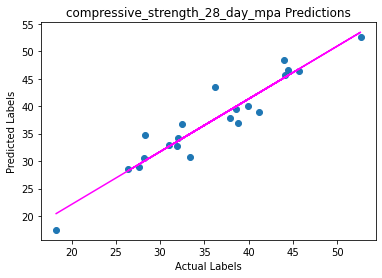

In [75]:
# Evaluate the model using the test data
linear = LinearRegression().fit(X_train_scaled, y_train)
y_pred = linear.predict(X_test_scaled)
y_train_pred = linear.predict(X_train_scaled)

ls =train_val(y_train, y_train_pred, y_test, y_pred, "linear")
print(ls)
print(colored('*'*100, 'red', attrs=['bold']), sep='')

# Plot predicted vs actual
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('compressive_strength_28_day_mpa Predictions')
# overlay the regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()


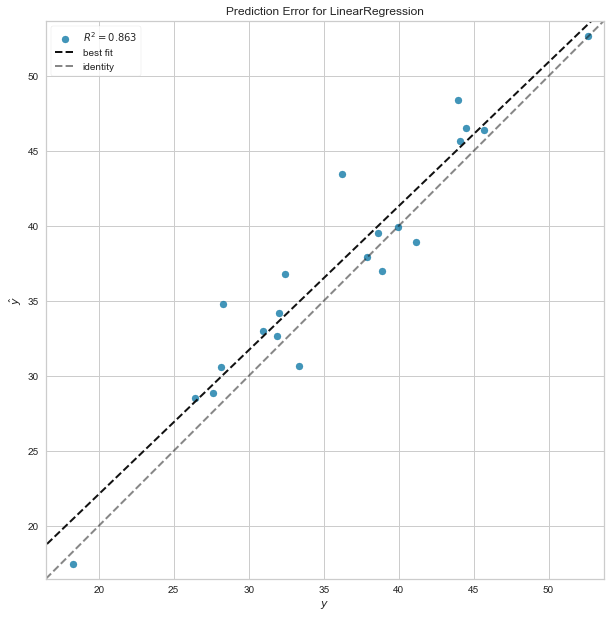

In [76]:
from yellowbrick.regressor import PredictionError
from yellowbrick.features import RadViz

visualizer = RadViz(size=(720, 3000))
model = LinearRegression()
visualizer = PredictionError(model)
visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();

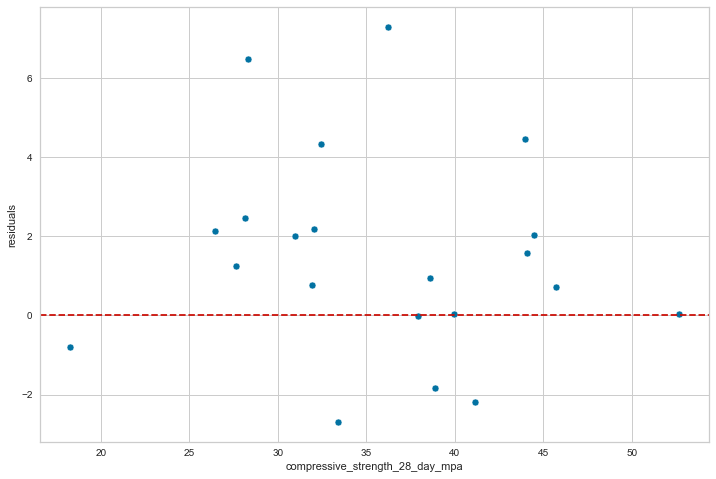

In [77]:
plt.figure(figsize=(12,8))
residuals = y_test-y_pred

sns.scatterplot(x = y_test, y = -residuals) #-residuals
plt.axhline(y = 0, color ="r", linestyle = "--")
plt.ylabel("residuals")
plt.show()

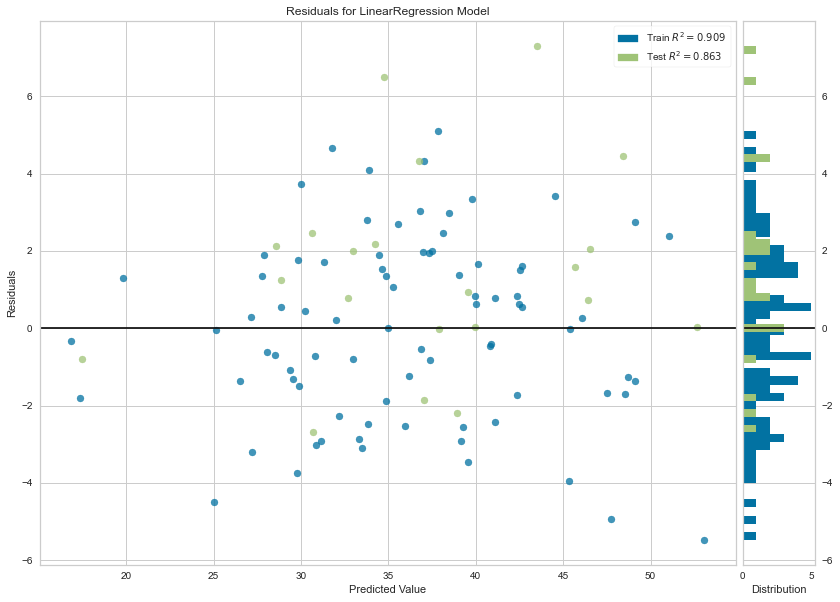

In [78]:
from yellowbrick.regressor import ResidualsPlot

visualizer = RadViz(size=(1000, 720))
model = LinearRegression()
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show();   

    Actual   Pred  Residual
31  43.950 48.401    -4.451
32  52.650 52.686    -0.036
14  32.440 36.771    -4.331
6   38.860 37.016     1.844
1   41.140 38.949     2.191
92  44.480 46.518    -2.038
61  39.930 39.957    -0.027
43  27.620 28.872    -1.252
16  28.290 34.776    -6.486
37  18.260 17.464     0.796
71  28.160 30.621    -2.461
53  38.590 39.527    -0.937
50  45.690 46.414    -0.724
21  36.190 43.490    -7.300
80  26.420 28.555    -2.135
25  33.380 30.687     2.693
97  44.080 45.659    -1.579
88  37.920 37.900     0.020
69  31.900 32.676    -0.776
85  30.970 32.980    -2.010


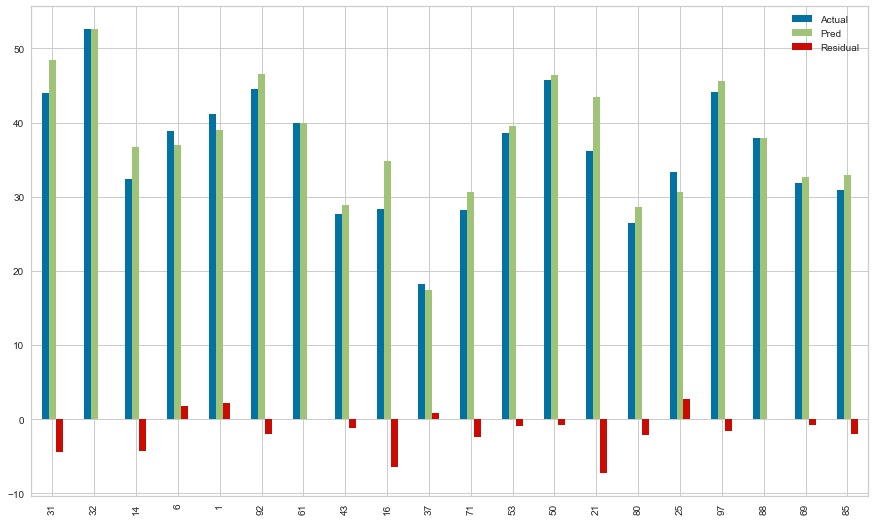

In [79]:
my_dict = { 'Actual': y_test, 'Pred': y_pred, 'Residual': y_test-y_pred }
compare = pd.DataFrame(my_dict)

comp_sample = compare.sample(20)
print(comp_sample)

comp_sample.plot(kind='bar',figsize=(15,9))
plt.show()

# 2. Regularization

## 2.1 Ridge (Apply and evaluate)

In [80]:
from sklearn.linear_model import Ridge

Ridge(random_state=101) 

      ridge_train  ridge_test
R2          0.908       0.861
mae         1.920       2.231
mse         5.549       8.661
rmse        2.356       2.943


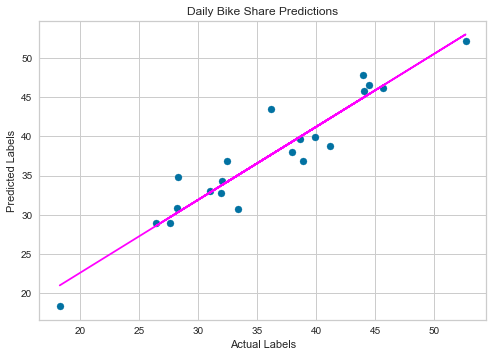

In [81]:
# Fit Ridge model on the training set
ridge = Ridge(random_state=101).fit(X_train_scaled, y_train)
print (ridge, "\n")

# Evaluate the model using the test data
y_pred = ridge.predict(X_test_scaled)
y_train_pred = ridge.predict(X_train_scaled)

rs =train_val(y_train, y_train_pred, y_test, y_pred, "ridge")
print(rs)

# Plot predicted vs actual
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')

# overlay the regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [82]:
ridge = Ridge(random_state=101)
scores = cross_validate(ridge, X_train_scaled, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 10)

scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                             0.787
test_neg_mean_absolute_error       -2.181
test_neg_mean_squared_error        -7.198
test_neg_root_mean_squared_error   -2.606
dtype: float64

In [83]:
pd.concat([ls, rs], axis=1)

,linear_train,linear_test,ridge_train,ridge_test
R2,0.909,0.863,0.908,0.861
mae,1.943,2.203,1.920,2.231
mse,5.489,8.554,5.549,8.661
rmse,2.343,2.925,2.356,2.943


<IPython.core.display.Javascript object>

Best parameter combination: {'alpha': 2.03} 

Ridge(alpha=2.03, max_iter=100000, random_state=101) 

      ridge_grid_train  ridge_grid_test
R2               0.907            0.859
mae              1.921            2.274
mse              5.643            8.765
rmse             2.376            2.961


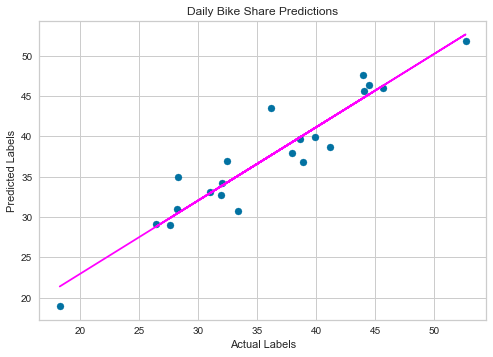

In [84]:
# Use Ridge algorithm
alg = Ridge(max_iter=100000, random_state=101)

# Try these hyperparameter values
alpha_space = np.linspace(0.01, 100, 100)

param_grid = {'alpha':alpha_space}

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, param_grid, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(X_train_scaled, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
ridge_grid=gridsearch.best_estimator_
print(ridge_grid, "\n")

# Evaluate the model using the test data
# Evaluate the model using the test data
y_pred = ridge_grid.predict(X_test_scaled)
y_train_pred = ridge_grid.predict(X_train_scaled)

rgs =train_val(y_train, y_train_pred, y_test, y_pred, "ridge_grid")
print(rgs)

# Plot predicted vs actual
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [85]:
pd.concat([ls, rs, rgs], axis = 1)

,linear_train,linear_test,ridge_train,ridge_test,ridge_grid_train,ridge_grid_test
R2,0.909,0.863,0.908,0.861,0.907,0.859
mae,1.943,2.203,1.920,2.231,1.921,2.274
mse,5.489,8.554,5.549,8.661,5.643,8.765
rmse,2.343,2.925,2.356,2.943,2.376,2.961


## 2.2 Lasso (Apply and evalute)

In [86]:
from sklearn.linear_model import Lasso

Lasso(random_state=101) 

      lasso_train  lasso_test
R2          0.791       0.719
mae         2.850       3.433
mse        12.628      17.507
rmse        3.554       4.184


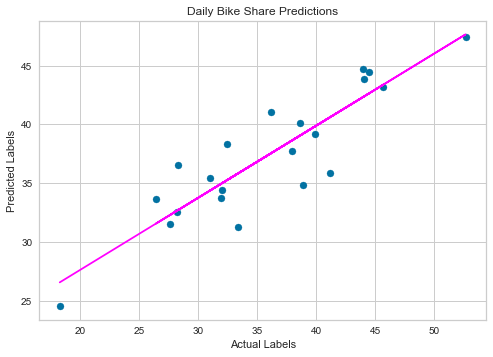

In [87]:
# Fit a lasso model on the training set
lasso = Lasso(random_state=101).fit(X_train_scaled, y_train)
print (lasso, "\n")

# Evaluate the model using the test data
y_pred = lasso.predict(X_test_scaled)
y_train_pred = lasso.predict(X_train_scaled)

lss =train_val(y_train, y_train_pred, y_test, y_pred, "lasso")
print(lss)

# Plot predicted vs actual
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [88]:
pd.concat([ls, rs, rgs, lss], axis = 1)

,linear_train,linear_test,ridge_train,ridge_test,ridge_grid_train,ridge_grid_test,lasso_train,lasso_test
R2,0.909,0.863,0.908,0.861,0.907,0.859,0.791,0.719
mae,1.943,2.203,1.920,2.231,1.921,2.274,2.850,3.433
mse,5.489,8.554,5.549,8.661,5.643,8.765,12.628,17.507
rmse,2.343,2.925,2.356,2.943,2.376,2.961,3.554,4.184


In [89]:
lasso = Lasso(random_state=101)
scores = cross_validate(lasso, X_train_scaled, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 10)

scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                              0.664
test_neg_mean_absolute_error        -3.093
test_neg_mean_squared_error        -15.148
test_neg_root_mean_squared_error    -3.775
dtype: float64

In [90]:
from sklearn.model_selection import GridSearchCV

Best parameter combination: {'alpha': 0.01} 

Lasso(alpha=0.01, max_iter=100000, random_state=101) 

      lasso_grid_train  lasso_grid_test
R2               0.909            0.862
mae              1.925            2.239
mse              5.518            8.606
rmse             2.349            2.934


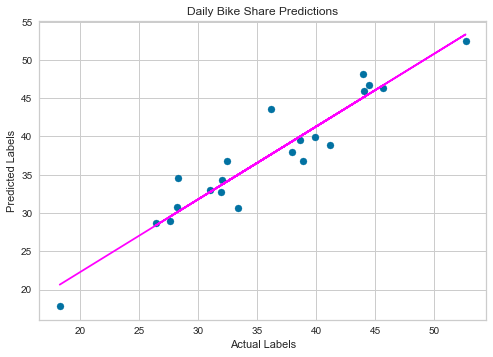

In [91]:
# Use Lasso algorithm
alg = Lasso(max_iter=100000, random_state=101)

# Try these hyperparameter values
alpha_space = np.linspace(0.01, 100, 100)

param_grid = {'alpha':alpha_space}

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, param_grid, scoring=score, cv=5, return_train_score=True)
gridsearch.fit(X_train_scaled, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
lasso_grid=gridsearch.best_estimator_
print(lasso_grid, "\n")


# Evaluate the model using the test data
y_pred = lasso_grid.predict(X_test_scaled)
y_train_pred = lasso_grid.predict(X_train_scaled)

lsgs =train_val(y_train, y_train_pred, y_test, y_pred, "lasso_grid")
print(lsgs)

# Plot predicted vs actual
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [92]:
pd.concat([ls, rs, rgs, lss, lsgs], axis = 1)

,linear_train,linear_test,ridge_train,ridge_test,ridge_grid_train,ridge_grid_test,lasso_train,lasso_test,lasso_grid_train,lasso_grid_test
R2,0.909,0.863,0.908,0.861,0.907,0.859,0.791,0.719,0.909,0.862
mae,1.943,2.203,1.920,2.231,1.921,2.274,2.850,3.433,1.925,2.239
mse,5.489,8.554,5.549,8.661,5.643,8.765,12.628,17.507,5.518,8.606
rmse,2.343,2.925,2.356,2.943,2.376,2.961,3.554,4.184,2.349,2.934


## 2.3 Elastic-Net (Apply and evaluate )
* Use Gridsearch for hyperparameter tuning instead of ElacticnetCV

In [93]:
from sklearn.linear_model import ElasticNet

ElasticNet(random_state=101) 

      elastic_train  elastic_test
R2            0.651         0.590
mae           3.722         4.175
mse          21.103        25.532
rmse          4.594         5.053


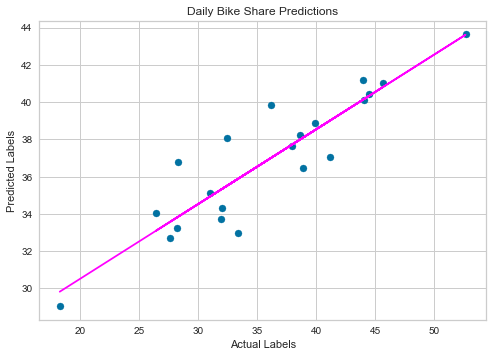

In [94]:
# Fit a lasso model on the training set
elastic = ElasticNet(random_state=101).fit(X_train_scaled, y_train)
print (elastic, "\n")

# Evaluate the model using the test data
y_pred = elastic.predict(X_test_scaled)
y_train_pred = elastic.predict(X_train_scaled)

es =train_val(y_train, y_train_pred, y_test, y_pred, "elastic")
print(es)

# Plot predicted vs actual
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [95]:
pd.concat([ls, rs, rgs, lss, lsgs, es], axis = 1).T

,R2,mae,mse,rmse
linear_train,0.909,1.943,5.489,2.343
linear_test,0.863,2.203,8.554,2.925
ridge_train,0.908,1.920,5.549,2.356
ridge_test,0.861,2.231,8.661,2.943
ridge_grid_train,0.907,1.921,5.643,2.376
ridge_grid_test,0.859,2.274,8.765,2.961
lasso_train,0.791,2.850,12.628,3.554
lasso_test,0.719,3.433,17.507,4.184
lasso_grid_train,0.909,1.925,5.518,2.349
lasso_grid_test,0.862,2.239,8.606,2.934


In [96]:
elastic = ElasticNet(random_state=101)
scores = cross_validate(elastic, X_train_scaled, y_train, scoring = ['r2', 'neg_mean_absolute_error','neg_mean_squared_error', \
                                                            'neg_root_mean_squared_error'], cv = 10)

scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                              0.484
test_neg_mean_absolute_error        -3.977
test_neg_mean_squared_error        -24.711
test_neg_root_mean_squared_error    -4.835
dtype: float64

Best parameter combination: {'alpha': 0.2, 'l1_ratio': 1} 

Lasso(alpha=0.01, max_iter=100000, random_state=101) 

      elastic_grid_train  elastic_grid_test
R2                 0.898              0.838
mae                1.973              2.584
mse                6.168             10.048
rmse               2.484              3.170


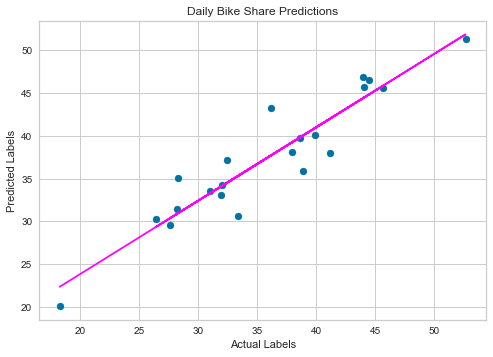

In [97]:
# Use ElasticNet algorithm
alg = ElasticNet(max_iter=100000, random_state=101)

# Try these hyperparameter values
# alpha_space = np.linspace(0.01, 100, 100)

param_grid = {"alpha":[0.01, 0.012, 0.2, 0.5, 0.6, 0.7, 1],
            "l1_ratio":[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]}

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, param_grid, scoring=score, cv=5, return_train_score=True)
gridsearch.fit(X_train_scaled, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
elastic_grid=gridsearch.best_estimator_
print(lasso_grid, "\n")


# Evaluate the model using the test data
y_pred = elastic_grid.predict(X_test_scaled)
y_train_pred = elastic_grid.predict(X_train_scaled)

egs =train_val(y_train, y_train_pred, y_test, y_pred, "elastic_grid")
print(egs)

# Plot predicted vs actual
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Daily Bike Share Predictions')
# overlay the regression line
z = np.polyfit(y_test, y_pred, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')
plt.show()

In [98]:
pd.concat([ls, rs, rgs, lss, lsgs, es, egs], axis = 1).T

,R2,mae,mse,rmse
linear_train,0.909,1.943,5.489,2.343
linear_test,0.863,2.203,8.554,2.925
ridge_train,0.908,1.920,5.549,2.356
ridge_test,0.861,2.231,8.661,2.943
ridge_grid_train,0.907,1.921,5.643,2.376
ridge_grid_test,0.859,2.274,8.765,2.961
lasso_train,0.791,2.850,12.628,3.554
lasso_test,0.719,3.433,17.507,4.184
lasso_grid_train,0.909,1.925,5.518,2.349
lasso_grid_test,0.862,2.239,8.606,2.934


In [99]:
# compare = pd.DataFrame({"Model": ["GB_model", "GB_tuned", "KNN_Model", "KNN_tuned3", "RF_model", "RF_tuned", "CB_model", 
#                                   "CB_tuned"],
                        
#                         "F1_Score": [GB_model_f1, GB_tuned_f1, KNN_model_f1, KNN_tuned3_f1, RF_model_f1, RF_tuned_f1, 
#                                      CB_model_f1, CB_tuned_f1],
                                                 
#                         "Accuracy_Score": [GB_model_acc, GB_tuned_acc, KNN_model_acc, KNN_tuned3_acc, RF_model_acc, 
#                                            RF_tuned_acc, CB_model_acc, CB_tuned_acc],
                        
#                         "Recall_Score": [GB_model_recall, GB_tuned_recall, KNN_model_recall, KNN_tuned3_recall, RF_model_recall, 
#                                          RF_tuned_recall, CB_model_recall, CB_tuned_recall],
                       
#                         "ROC_AUC_Score": [GB_model_auc, GB_tuned_auc, KNN_model_auc, KNN_tuned3_auc, RF_model_auc, 
#                                           RF_tuned_auc, CB_model_auc, CB_tuned_auc]})

# compare = compare.sort_values(by="Recall_Score", ascending=True)
# fig = px.bar(compare, x = "Recall_Score", y = "Model", title = "Recall_Score")
# fig.show()

# compare = compare.sort_values(by="F1_Score", ascending=True)
# fig = px.bar(compare, x = "F1_Score", y = "Model", title = "F1_Score")
# fig.show()

# compare = compare.sort_values(by="Accuracy_Score", ascending=True)
# fig = px.bar(compare, x = "Accuracy_Score", y = "Model", title = "Accuracy_Score")
# fig.show()

# compare = compare.sort_values(by="ROC_AUC_Score", ascending=True)
# fig = px.bar(compare, x = "ROC_AUC_Score", y = "Model", title = "ROC_AUC_Score")
# fig.show()